## Sensitivity encoded MRI reconstruction

* __Two sets of data were acquired with 4-shot spin-echo EPI at different echo times__
* __The matrix size for each echo image is $128 \times 128 \times 8 $  (xres=128; yres=128; coil_number=8)__

In [1]:
push!(LOAD_PATH,"library");
using PyPlot
using NK_tools

In [2]:
fid = open("data/kdata_4s_seepi");
kdata_4s_seepi = read(fid, Complex128,(128,128,8,2));
close(fid);

In [3]:
kdata_echo1 = kdata_4s_seepi[:,:,:,1];
kdata_echo2 = kdata_4s_seepi[:,:,:,2];

In [4]:
imgdata_echo1 = qft(copy(kdata_echo1));
imgdata_echo2 = qft(copy(kdata_echo2));

11796481179648

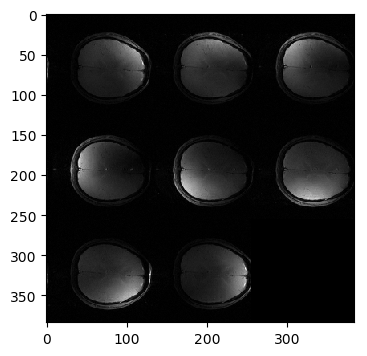

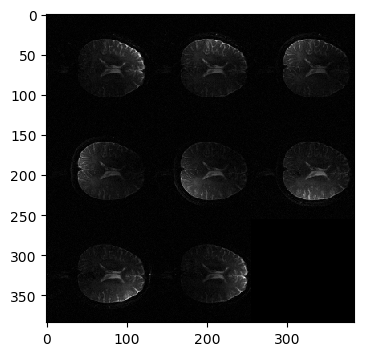

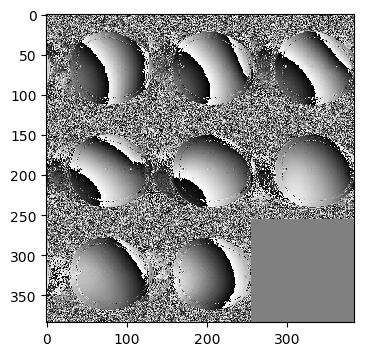

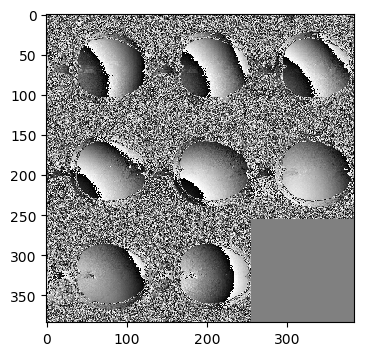

In [5]:
figure(1,figsize=(4,4));imal(abs.(imgdata_echo1),3,3)
figure(2,figsize=(4,4));imal(abs.(imgdata_echo2),3,3)
figure(3,figsize=(4,4));imal(angle.(imgdata_echo1),3,3)
figure(4,figsize=(4,4));imal(angle.(imgdata_echo2),3,3);

* __We could combine the information from 8 RF coil channels with "root-mean-square"__

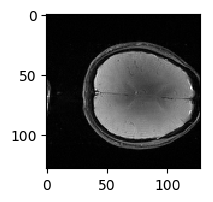

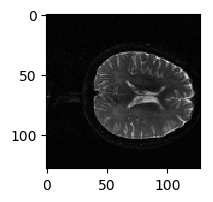

In [6]:
combinedData_echo1 = rmsCombineDataCoils(imgdata_echo1);
combinedData_echo2 = rmsCombineDataCoils(imgdata_echo2);
figure(1,figsize=(2,2));imshow(combinedData_echo1[:,:,1],cmap="gray")
figure(2,figsize=(2,2));imshow(combinedData_echo2[:,:,1],cmap="gray");

* __Calculation of coil sensitivity profiles from the first echo image__

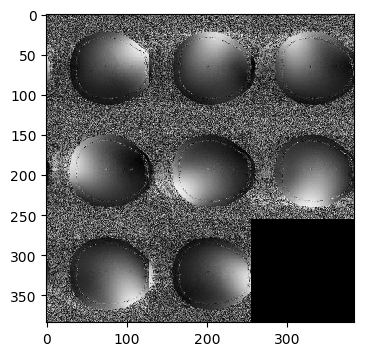

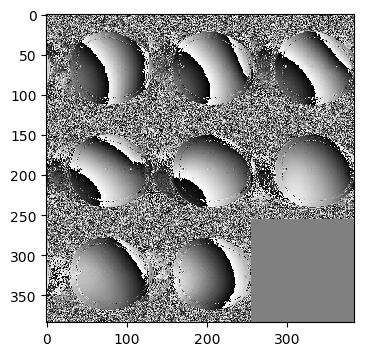

11796481179648

In [7]:
coilSensitivityProfile1 = imgdata_echo1./combinedData_echo1;
figure(1,figsize=(4,4));imal(abs.(coilSensitivityProfile1),3,3)
figure(2,figsize=(4,4));imal(angle.(coilSensitivityProfile1),3,3);

* __Assuming that we have only acquied 50% of the k-space data for echo image 2 (with only odd ky lines acquired), what would the reconstructed images look like?__

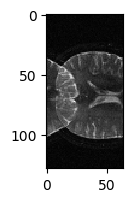

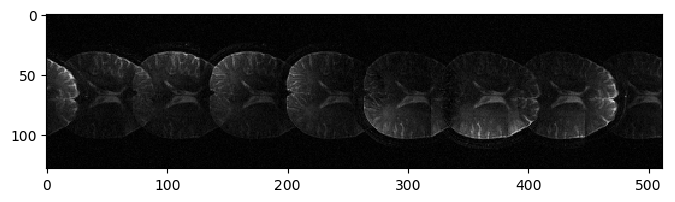

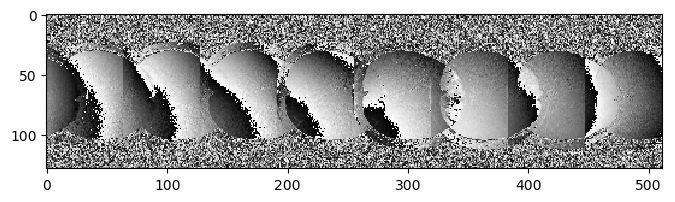

524288524288

In [8]:
kData_acquired = kdata_echo2[:,1:2:end,:];
imgdata_acquired = qft(copy(kData_acquired));
figure(1,figsize=(2,2));imshow(rmsCombineDataCoils(imgdata_acquired)[:,:,1],cmap="gray")
figure(2,figsize=(8,2));imal(abs.(imgdata_acquired),8,1)
figure(3,figsize=(8,2));imal(angle.(imgdata_acquired),8,1);

* __Does zero-filling k-space data change anything?__

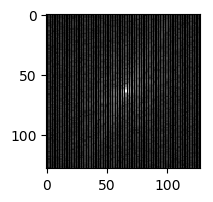

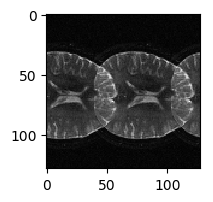

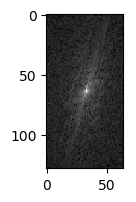

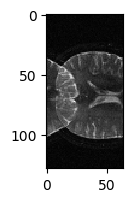

In [9]:
kData_acquired_zeroFilled = zeros(Complex128,size(kData_acquired)[1],size(kData_acquired)[2]*2,size(kData_acquired)[3]);
kData_acquired_zeroFilled[:,1:2:end,:] = kData_acquired;
imgdata_acquired_zeroFilled = qft(copy(kData_acquired_zeroFilled))
figure(1,figsize=(2,2));imshow(abs.(kData_acquired_zeroFilled[:,:,1]).^0.3,cmap="gray");
figure(2,figsize=(2,2));imshow(rmsCombineDataCoils(imgdata_acquired_zeroFilled)[:,:,1],cmap="gray");
figure(3,figsize=(2,2));imshow(abs.(kData_acquired[:,:,1]).^0.3,cmap="gray");
figure(4,figsize=(2,2));imshow(rmsCombineDataCoils(imgdata_acquired)[:,:,1],cmap="gray");

* __Recovering FOV and aliasing-free images from under-sampled data using the coil sensitivity profiles__

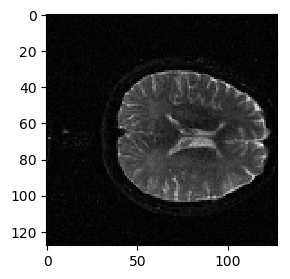

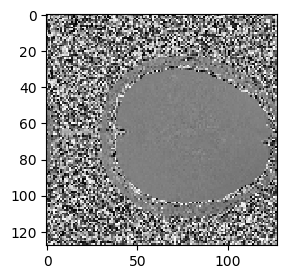

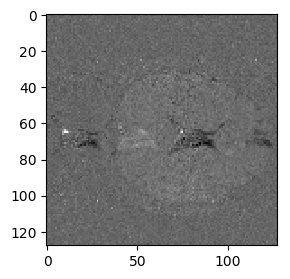

In [10]:
sense_reconstructed_image = zeros(Complex128,size(kData_acquired)[1],size(kData_acquired)[2]*2);
for cntx = 1:size(kData_acquired)[1]
    for cnty = 1: size(kData_acquired)[2]
        mat1 = imgdata_acquired_zeroFilled[cntx,cnty,:];
        mat2 = hcat(coilSensitivityProfile1[cntx,cnty,:],coilSensitivityProfile1[cntx,cnty+size(kData_acquired)[2],:])
        mat3 = mat2\mat1;
        sense_reconstructed_image[cntx,cnty]=mat3[1];
        sense_reconstructed_image[cntx,cnty+size(kData_acquired)[2]]=mat3[2];
    end
end
figure(1,figsize=(3,3));imshow(abs.(sense_reconstructed_image),cmap="gray")
figure(2,figsize=(3,3));imshow(angle.(sense_reconstructed_image),cmap="gray")
figure(3,figsize=(3,3));imshow(abs.(sense_reconstructed_image)*2-combinedData_echo2[:,:,1],cmap="gray");

### Questions and exercise

* Can we simply average information from 8 RF channels instead using room-mean-square?
* What if we have only 4 RF channels? will the SENSE reconstruction work?
* What if we have only 2 RF channels? will the SENSE reconstruction work?
* Should we smooth coil sensitivity profiles? Will that improve the SNR of SENSE-reconstructed images?
* How can we use regularization to reduce noise amplification?
* Can we reconstruct full FOV images from only 25% of the k-space data (e.g., $k_y$ line # 1, 5, 9 ...)?
